### Imports

In [1]:
%matplotlib notebook
import matplotlib as mpl
mpl.style.use('paper.rc')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import pandas as pd
import numpy as np
import os, glob
import data_tools as dt

/usr/local/lib/python3.6/site-packages/h5py-2.7.1-py3.6-macosx-10.11-x86_64.egg/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%load_ext autoreload
%autoreload 2

### Directories

In [3]:
data_dir = os.path.join('./raw_data')
analysis_dir = os.path.join('./analysis')
fig_dir = os.path.join('./figures')

### Constants

Determined in `characterize_dot.ipynb`

In [4]:
MU_B = 5.7883818012e-5 # eV/T
K_B = 8.6173303e-5 # eV/K

ALPHA1_CLSD = 0.0469
ALPHA1_OPN = 0.0295
G1_OPN = 0.388
ALPHA2_CLSD = 0.0442
ALPHA2_OPN = 0.0333
G2_OPN = 0.400
ALPHA3_CLSD = 0.0415
ALPHA3_CLSD = 0.0265
G3_OPN = 0.395

# Figure 1

<IPython.core.display.Javascript object>


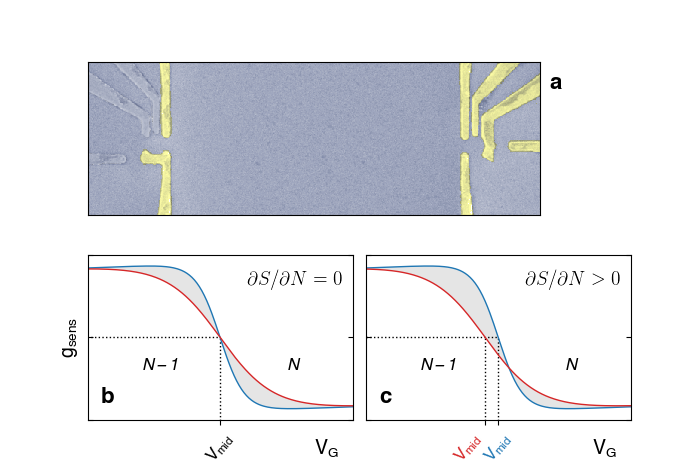

In [7]:
### setup figure
fig = plt.figure(figsize=dt.mm2inch((89*2,120)))

outer = gridspec.GridSpec(2, 1, height_ratios = [1,1], hspace=0.2)

gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = outer[0],
                                          width_ratios=[5,1], wspace=0)

ax0 = fig.add_subplot(gs1[0,0]) # image
axE = fig.add_subplot(gs1[0,1]) # label/annotation space
axE.axis('off')

gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = outer[1],
                                        width_ratios=[1,1], wspace=0.05)
ax1 = fig.add_subplot(gs2[0,0]) # g_sens du=0
ax2 = fig.add_subplot(gs2[0,1], sharey=ax1) # g_sens du!=0

############################
### display device image ###
############################

ax0.imshow(mpl.image.imread(os.path.join(fig_dir,'device_cropped.png')))
ax0.set_xticks([])
ax0.xaxis.set_major_formatter(plt.NullFormatter())
ax0.set_yticks([])
ax0.yaxis.set_major_formatter(plt.NullFormatter())

##########################
### fake g and dg data ###
##########################

V0 = -487.5 # mV
dV0 = -0.69*K_B/(0.04)*0
theta1 = 0.275 # mV
theta2 = 0.600 # mV

xnew = np.linspace(-494,-480, 500)
enew = (xnew-V0)*0.04*1000
g1 = dt.i_sense(xnew, V0, theta1, 0.045, 10e-4, 0.5)
g2 = dt.i_sense(xnew, V0+dV0, theta2, 0.045, 10e-4, 0.5)
ax1.plot(enew, g1, c='C0')
ax1.plot(enew, g2, c='C3')
ax1.fill_between(enew, g1, g2, facecolor='C7', alpha=0.2)
ax1.vlines(0, 0, 0.5, color='k', linestyle=":")
ax1.hlines(0.5, -150, 0, color='k', linestyle=":")

dV0 = -0.69*K_B/(0.04)*200
g1 = dt.i_sense(xnew, V0, theta1, 0.045, 10e-4, 0.5)
g2 = dt.i_sense(xnew, V0+dV0, theta2, 0.045, 10e-4, 0.5)
ax2.plot(enew, g1, c='C0')
ax2.plot(enew, g2, c='C3')
ax2.fill_between(enew, g1, g2, facecolor='C7', alpha=0.2)
ax2.vlines(0, 0, 0.5, color='k', linestyle=":")
ax2.vlines(dV0*0.04*1e3, 0, 0.5, color='k', linestyle=":")
ax2.hlines(0.5, -150, 0, color='k', linestyle=":")

ax1.set_ylim(0.45,0.55)
ax1.set_xlim(-120,120)
ax2.set_xlim(-120,120)

ax1.set_xticks([0])
ax1.set_xticklabels([r'V$_{mid}$'], rotation=50)
ax1.set_xlabel(r'V$_{G}$', x=0.9, labelpad=-20)
ax1.tick_params(axis='x', top=False)
ax1.tick_params(axis='x', direction='out')

ax2.set_xticks([dV0*0.04*1e3, 0])
ax2.set_xticklabels([r'V$_{mid}$', r'V$_{mid}$'], rotation=50)
ax2.tick_params(axis='x', top=False)
ax2.tick_params(axis='x', direction='out')

ax1.set_ylabel(r'g$_{sens}$')
ax2.set_xlabel(r'V$_{G}$', x=0.9, labelpad=-20)
ax1.set_yticklabels([])
ax2.set_yticklabels([])
colors = ['C3', 'C0']
aligns = ['right', 'center']
for xtick, color, align in zip(ax2.get_xticklabels(), colors, aligns):
    xtick.set_color(color)
    xtick.set_horizontalalignment(align)
    
with plt.rc_context({"text.usetex": True}):
    ax1.text(0.6, 0.8, r'$\partial S / \partial N = 0$', 
                 transform=ax1.transAxes, fontstyle='italic')
    ax2.text(0.6, 0.8, r'$\partial S / \partial N > 0$', 
                 transform=ax2.transAxes)

ax1.text(0.20, 0.3, r'$N-1$', transform=ax1.transAxes, fontsize=12, fontstyle='italic')
ax1.text(0.75, 0.3, r'$N$', transform=ax1.transAxes, fontsize=12, fontstyle='italic')
ax2.text(0.20, 0.3, r'$N-1$', transform=ax2.transAxes, fontsize=12, fontstyle='italic')
ax2.text(0.75, 0.3, r'$N$', transform=ax2.transAxes, fontsize=12, fontstyle='italic')

dt.add_subplot_id(axE, 'a', loc = (0.1, 0.8))
dt.add_subplot_id(ax1, 'b', loc = (0.05, 0.1))
dt.add_subplot_id(ax2, 'c', loc = (0.05, 0.1))

fig.savefig(os.path.join(fig_dir, 'figure_1_s-annotation.pdf'))

# Figure 2

<IPython.core.display.Javascript object>


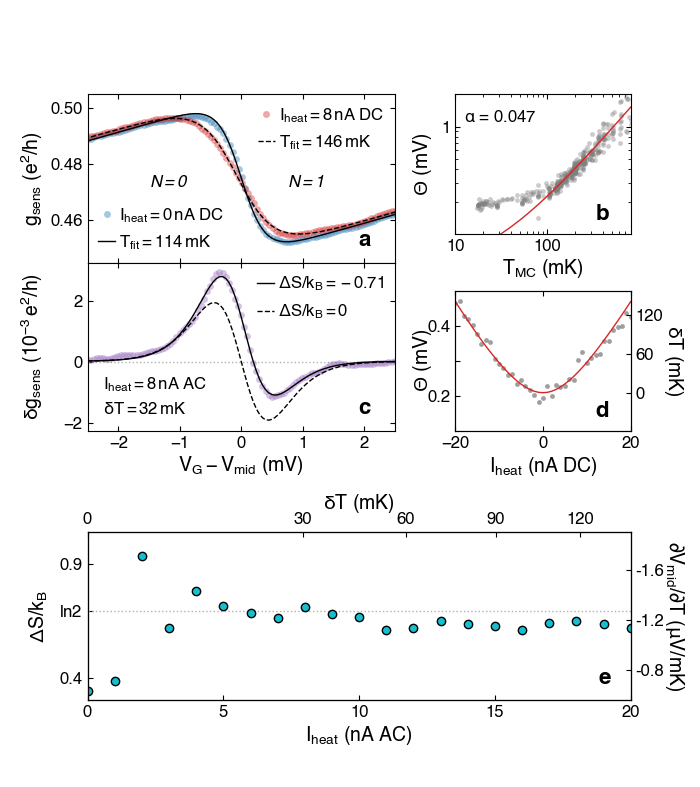

In [54]:
### setup figure

fig = plt.figure(figsize=dt.mm2inch((89*2,200)))
outer = gridspec.GridSpec(2, 2, height_ratios = [2, 1], width_ratios = [1.75,1],
                             hspace=0.4, wspace=0.25)

gs1 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer[0,0],
                                       height_ratios = [1, 1], hspace=0)
ax0 = fig.add_subplot(gs1[0,0]) # g vs gate
ax1 = fig.add_subplot(gs1[1,0]) # dg vs gate

gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer[0,1], hspace=0.4)
ax2 = fig.add_subplot(gs2[0]) # alpha calibration
ax3 = fig.add_subplot(gs2[1]) # theta/dT calibration

ax4 = fig.add_subplot(outer[1,:]) # dS vs P

# left y labels
ax0_ylabel_pos = (-0.14,0.5)
ax1_ylabel_pos = (-0.14,0.5)
ax4_ylabel_pos = (-0.14/2,0.5)

# middle y labels
ax2_ylabel_pos = (-0.12,0.5)
ax3_ylabel_pos = (-0.12,0.5)

# right y labels
ax3a_ylabel_pos = (1.0+0.18,0.5)
ax4b_ylabel_pos = (1.0+0.18/3,0.5)

#################
### g vs gate ###
#################

swp = dt.open_hdf5(944, path=data_dir) # load sweep data
x, z = dt.moving_avg(0.5*swp['x_array'][:], swp['i_sense_dc2d'][:]*1e9, 8, axis=1)
i_results = pd.read_csv(os.path.join(analysis_dir, 'dat944_i_results.csv'))

x20 = i_results.loc[20,'x0']
ax0.scatter(x-x20, z[20]*(1e-9)/(35e-3*1e-2)/(3.874e-5), 
            marker='o', color='C0', alpha=0.4, s=24, lw=0)
ax0.scatter(x-x20, z[28]*(1e-9)/(35e-3*1e-2)/(3.874e-5), 
            marker='o', color='C3', alpha=0.4, s=24, lw=0)

ax0.plot(x-x20, dt.i_sense(x, *i_results.iloc[20,:-3].values)*(1e-9)/(35e-3*1e-2)/(3.874e-5), 
         c='k', ls='-')
ax0.plot(x-x20, dt.i_sense(x, *i_results.iloc[28,:-3].values)*(1e-9)/(35e-3*1e-2)/(3.874e-5), 
         c='k', ls='--')

ax0.set_xlim(-2.5,2.5)
ax0.set_xticklabels([])
ax0.set_ylim(0.445, 0.505)
ax0.set_ylabel(r'g$_{sens}$ $(e^2/h)$')
ax0.get_yaxis().set_label_coords(*ax0_ylabel_pos)
         
# create legend(s)
line_cold = mpl.lines.Line2D([], [], color='k', ls='-')
scatter_cold = mpl.lines.Line2D([], [], ls='', 
                                 marker='o', color='C0', alpha=0.4, 
                                 markeredgewidth=0, markersize=5)
line_hot = mpl.lines.Line2D([], [], color='k', ls='--')
scatter_hot = mpl.lines.Line2D([], [], ls='', 
                                marker='o', color='C3', alpha=0.4, 
                                markeredgewidth=0, markersize=5)
handles = [scatter_cold, line_cold]
labels = [r'I$_{heat}=0\,$nA DC', r'T$_{fit} = 114\,$mK']
legend_cold = ax0.legend(handles, labels, loc='lower left')
ax0.add_artist(legend_cold)
handles = [scatter_hot, line_hot]
labels = [r'I$_{heat}=8\,$nA DC', r'T$_{fit} = 146\,$mK'] 
legend_hot = ax0.legend(handles, labels, loc='upper right')

# add N
ax0.text(0.2, 0.45, r'$N=0$', transform=ax0.transAxes, fontsize=12, fontstyle='italic')
ax0.text(0.65, 0.45, r'$N=1$', transform=ax0.transAxes, fontsize=12, fontstyle='italic')

##################
### dg vs gate ###
##################

swp = dt.open_hdf5(945, path=data_dir) 
x, z = dt.moving_avg(0.5*swp['x_array'][:], swp['g5x2d'][:], 4, axis=1)
z = z*(1e-8)*(1e9) # nA

di_free = pd.read_csv(os.path.join(analysis_dir, 'dat945_di_free_fits.csv'))
di_zero = pd.read_csv(os.path.join(analysis_dir, 'dat945_di_zero_fits.csv'))

ax1.axhline(y=0, lw=1, c='#b0b0b0', ls=':', zorder=1)
ax1.scatter(x-di_free.loc[8,'x0'], z[8]*(1e-6)/(35e-3*1e-2)/(3.874e-5), 
                marker='o', color='C4', lw=0, alpha=0.4, s=24, zorder=2)

ax1.plot(x-di_free.loc[8,'x0'], 
         (1e-6)*dt.di_sense_simple(x, *di_free.iloc[8,5:].values)/(35e-3*1e-2)/(3.874e-5), 
         c='k', label=r'$\Delta S/k_B = {0:.2f}$'.format(1.0*di_free.loc[8,'epsilon']), 
         zorder=4)
ax1.plot(x-di_zero.loc[8,'x0'], 
             (1e-6)*dt.di_sense_simple(x, *di_zero.iloc[8,5:].values)/(35e-3*1e-2)/(3.874e-5), 
                 c='k', ls='--', label=r'$\Delta S/k_B = 0$', zorder=3)

ax1.legend(loc='upper right')

ax1.set_xlim(-2.5,2.5)
ax1.set_xlabel('$V_G-V_{mid}$ (mV)')
ax1.set_ylabel('$\delta g_{sens}$ $(10^{-3} \, e^2/h)$')
ax1.get_yaxis().set_label_coords(*ax1_ylabel_pos)
ax1.set_ylim(-2.25, 3.25)

ax1.text(0.05, 0.25, '$I_{heat} = 8\,$nA AC', 
             transform=ax1.transAxes, fontsize = 12)
ax1.text(0.05, 0.1, '$\delta T = 32\,$mK', 
             transform=ax1.transAxes, fontsize = 12)

############################################
### lever arm measurement for closed dot ###
############################################

datafiles = ['lever-arm_peak1_dataset_{0:d}.csv'.format(i+1) for i in range(3)]
df = pd.concat((pd.read_csv(os.path.join(analysis_dir,f)) for f in datafiles), 
                   ignore_index=True)
df.sort_values(by='Tmc', ascending=True, inplace=True)

ax2.scatter(df['Tmc'], df['theta'], 
                marker='o', color='C7', lw=0, alpha=0.4, s=12)

tnew  = np.loadtxt(os.path.join(analysis_dir,'peak1_alpha-fit_temps.csv'),delimiter=",")
thetas = np.loadtxt(os.path.join(analysis_dir,'peak1_alpha-fit_thetas.csv'),delimiter=",")
ax2.plot(tnew, thetas, c='C3')

ax2.set_yscale('log')
ax2.set_ylim(0.1, 2.0)
ax2.set_yticks([1])
ax2.set_yticklabels(['1'])
ax2.set_ylabel(r'$\Theta$ (mV)')
ax2.get_yaxis().set_label_coords(*ax2_ylabel_pos)

ax2.set_xscale('log')
ax2.set_xlim(10, 800)
ax2.set_xticks([10, 100])
ax2.set_xticklabels(['10', '100'])
ax2.set_xlabel('T$_{MC}$ (mK)')

ax2.text(0.05, 0.8, r'$\alpha$ = {0:.3f}'.format(ALPHA1_CLSD), 
         transform=ax2.transAxes, fontsize=12)

###########################
### theta/dT calibration ###
###########################

i_results = pd.read_csv(os.path.join(analysis_dir, 'dat944_i_results.csv'))
ax3.scatter(i_results['i_heat'], i_results['theta'], 
           marker='o', alpha=0.75, color='C7', lw=0, s=12)

ax3.set_xlim(-20,20)
ax3.set_xlabel(r'$I_{heat}$ (nA DC)')

ax3.set_ylim(0.1, 0.5)
ax3.set_yticks([0.2, 0.3, 0.4])
ax3.set_yticklabels(['0.2', '', '0.4'])
ax3.set_ylabel(r'$\Theta$ (mV)')
ax3.get_yaxis().set_label_coords(*ax3_ylabel_pos)

theta_calc = np.loadtxt(os.path.join(analysis_dir, 'dat944_theta_calc.csv'), delimiter=',')
ax3.plot(i_results['i_heat'], theta_calc, c='C3')

# add dT axis
ax3a = ax3.twinx()
dTs = [0, 60, 120]
popt_pwr = np.loadtxt(os.path.join(analysis_dir, 'dat944_PtoTheta_fit.csv'), delimiter=',')
T_min = (ALPHA1_CLSD*popt_pwr[0]/(K_B))
thetas = [K_B*(dT+T_min)/ALPHA1_CLSD for dT in dTs]

ax3a.set_ylim(ax3.get_ylim())
ax3a.set_yticks(thetas)
ax3a.set_yticklabels(['0', '60', '120'])
ax3a.set_ylabel(r'$\delta T$ (mK)', rotation=-90, va='bottom', labelpad=-2)
ax3a.get_yaxis().set_label_coords(*ax3a_ylabel_pos)

####################
### dS vs P plot ###
####################

di_results = pd.read_csv(os.path.join(analysis_dir, 'dat945_di_free_fits.csv'))
ax4.axhline(y=1*np.log(2), c='#b0b0b0', ls=':', zorder=1)
ax4.scatter(di_results['i_heat'], -1.0*di_results['epsilon'], 
                    marker='o', facecolor='C9', edgecolor='k', zorder=2)

ax4.set_ylim(0.3, np.log(2)*1.5)
ax4.set_yticks([0.4, np.log(2), 0.9])
ax4.set_yticklabels(['0.4', '$\ln{2}$', '0.9'])
ax4.set_ylabel('$\Delta S/k_B$', labelpad=0)
ax4.get_yaxis().set_label_coords(*ax4_ylabel_pos)

ax4.set_xlim(0,20)
ax4.set_xticks([0,5,10,15,20])
ax4.set_xlabel('I$_{heat}$ (nA AC)')

# add dT axis
ax4a = ax4.twiny()

dTs = [0, 30, 60, 90, 120] 
Ts = [di_results['t_calc'][0] + d for d in dTs] # T_{electron} corresponding to dT
thetas = [K_B*t/ALPHA1_CLSD for t in Ts] # theta corresponding to dT
pwrs = [((t/popt_pwr[0])**2 - 1)/popt_pwr[1] for t in thetas]
popt_v = np.loadtxt(os.path.join(analysis_dir, 'dat945_voltage_fit.csv'), delimiter=',')
currents = [np.sqrt(1000*p/popt_v[0]) for p in pwrs]
currents[0] = 0 # small correction, must be true

ax4a.set_xlim(ax4.get_xlim())
ax4a.set_xticks(currents)
ax4a.set_xticklabels(dTs)
ax4a.set_xlabel(r'$\delta T$ (mK)')

# add dV/dT axis
ax4b = ax4.twinx()
dVdT = [-0.8e-3, -1.2e-3, -1.6e-3]
dS = [-1.0*ALPHA1_CLSD*v/K_B for v in dVdT]

ax4b.set_ylim(ax4.get_ylim())
ax4b.set_yticks(dS)
ax4b.set_yticklabels(['-0.8', '-1.2', '-1.6'])
ax4b.set_ylabel(r'$\partial V_{mid} / \partial T$ $(\mu V / mK)$', rotation=-90, va='bottom')
ax4b.get_yaxis().set_label_coords(*ax4b_ylabel_pos)

dt.add_subplot_id(ax0, 'a', loc = (0.88, 0.1))
dt.add_subplot_id(ax1, 'c', loc = (0.88, 0.1))
dt.add_subplot_id(ax2, 'b', loc = (0.8, 0.1))
dt.add_subplot_id(ax3, 'd', loc = (0.8, 0.1))
dt.add_subplot_id(ax4, 'e', loc = (0.94, 0.1))

fig.savefig(os.path.join(fig_dir, 'figure_2.pdf'))

# Figure 3

<IPython.core.display.Javascript object>


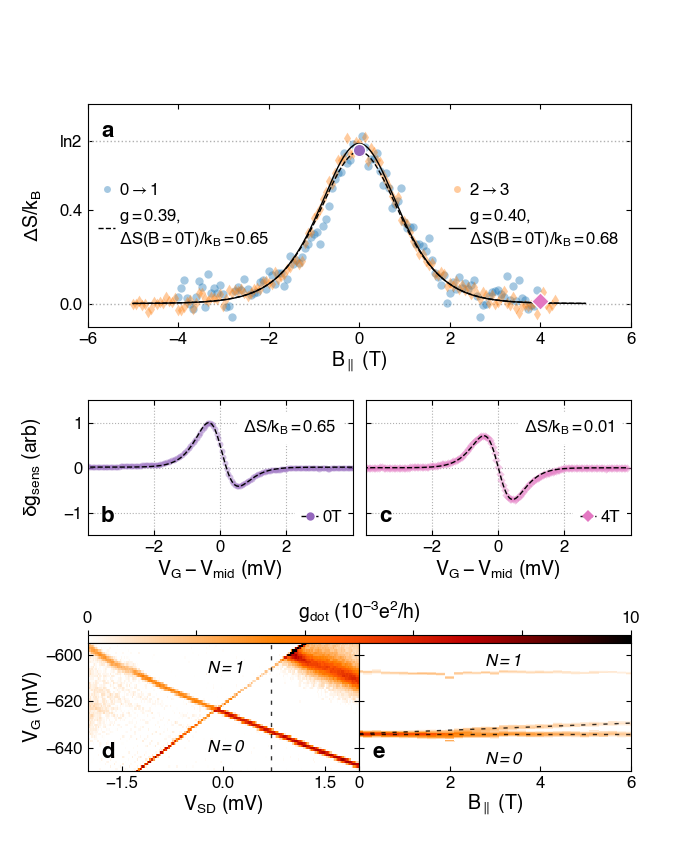

/usr/local/lib/python3.6/site-packages/matplotlib/mathtext.py:839: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


In [57]:
### setup figure ###
fig = plt.figure(figsize=dt.mm2inch((89*2,220)))

outer = gridspec.GridSpec(5, 1, height_ratios = [1.65,0.2,1,0.4,1])

gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0])
ax2 = fig.add_subplot(gs1[:]) # dS vs B

gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = outer[2],
                                           wspace=0.05)
ax3 = fig.add_subplot(gs2[0,0]) # dg 0T
ax4 = fig.add_subplot(gs2[0,1]) # dg 4T

gs3 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec = outer[4], 
                                           height_ratios = [0.06,1],
                                           wspace=0.0, hspace=0.0)

cax = fig.add_subplot(gs3[0,:]) # color bar
ax0 = fig.add_subplot(gs3[1,0]) # coulomb diamond
ax1 = fig.add_subplot(gs3[1,1]) # g factor data

# adjust left labels
ax2_ylabel_pos = (-0.16/2,0.5)
ax3_ylabel_pos = (-0.17,0.5)
ax0_ylabel_pos = (-0.16,0.5)

###############
### dS vs B ###
###############

### plot 01 data ###
df = pd.read_csv(os.path.join(analysis_dir, 'dat1011_di_free_fits.csv'))
ax2.scatter(df['field'], -1.0*df['epsilon'], 
               marker='o', color='C0', lw=0, alpha=0.4, zorder=2)

field = np.loadtxt(os.path.join(analysis_dir, 'dat1011_field.csv'))
dS = np.loadtxt(os.path.join(analysis_dir, 'dat1011_dS01_fit.csv'))
ax2.plot(field, dS, c='k', ls='--', lw=1, zorder=3)

### plot 23 data ###
df = pd.read_csv(os.path.join(analysis_dir, 'dat1442_di_free_fits.csv'))
ax2.scatter(df['field'], -1.0*df['epsilon'], 
               marker='d', color='C1', lw=0, alpha=0.4, zorder=2)

field = np.loadtxt(os.path.join(analysis_dir, 'dat1442_field.csv'))
dS = np.loadtxt(os.path.join(analysis_dir, 'dat1442_dS23_fit.csv'))
ax2.plot(field, dS, c='k', ls='-', zorder=3)

ax2.axhline(y=np.log(2), c='#b0b0b0', ls=':', zorder=1)
ax2.axhline(y=0, c='#b0b0b0', ls=':', zorder=1)

ax2.set_xlim(-6, 6)
ax2.set_ylim(-0.1, 0.85)

scatter_01 = mpl.lines.Line2D([], [], ls='', 
                               marker='o', color='C0', alpha=0.4, 
                               markeredgewidth=0, markersize=5, 
                               label=r'$0 \rightarrow 1$')
line_01 = mpl.lines.Line2D([], [], color='k', ls='--', 
            label=r'$g = {0:.2f}$,'.format(0.388) + '\n' +
                           r'$\Delta S(B=0T) / k_B = {0:.2f}$'.format(0.933*np.log(2)))
scatter_23 = mpl.lines.Line2D([], [], ls='', 
                               marker='o', color='C1', alpha=0.4, 
                               markeredgewidth=0, markersize=5, 
                               label=r'$2 \rightarrow 3$')
line_23 = mpl.lines.Line2D([], [], color='k', ls='-', 
            label=r'$g = {0:.2f}$,'.format(0.395) + '\n' +
                           r'$\Delta S(B=0T) / k_B = {0:.2f}$'.format(0.982*np.log(2)))

handles = [scatter_01, line_01]
labels = [h.get_label() for h in handles] 
legend_data = ax2.legend(handles, labels, loc='center left', fontsize=12)
ax2.add_artist(legend_data)
handles = [scatter_23, line_23]
labels = [h.get_label() for h in handles] 
legend_fit = ax2.legend(handles, labels, loc='center right', fontsize=12)

ax2.set_ylabel('$\Delta S/k_B$')
ax2.get_yaxis().set_label_coords(*ax2_ylabel_pos)
ax2.set_yticks([0.0, 0.4, np.log(2)])
ax2.set_yticklabels(['0.0', '0.4', r'$\ln{2}$'])
ax2.set_xlabel('B$_{\parallel}$ (T)')

#############################
### markers for line cuts ###
#############################

df = pd.read_csv(os.path.join(analysis_dir, 'dat1011_di_free_fits.csv'))
ax2.scatter(df.loc[60,'field'], -1.0*df.loc[60,'epsilon'], marker='o', s=80, zorder=4, 
            facecolors='C4', edgecolors='w')
ax2.scatter(df.loc[120,'field'], -1.0*df.loc[120,'epsilon'], marker='D', s=80, zorder=4, 
            facecolors='C6', edgecolors='w')

##########################
### dg at B=0 and B=4T ###
##########################

swp = dt.open_hdf5(1011, path=data_dir) # load sweep data
vy = swp['y_array'][:]/1000.0
vx, vz = dt.moving_avg(swp['x_array'][:]*0.5, swp['g5x2d'][:]*2e-8, 8, axis=1)
vz = vz*(1e3)/(35e-3*1e-2)/(3.874e-5) # 0.001e^2/h

ax3.scatter(vx-df.iloc[60,0], vz[60]/np.abs(vz[60]).max(), 
            marker='o', s=18, c='C4', lw=0, alpha=0.4)
di_fit = dt.di_sense_simple(vx, *df.iloc[60,:-1].values)
line0, = ax3.plot(vx-df.iloc[60,0], di_fit/np.abs(di_fit).max(), 
         c='k', ls='--')
ax3.text(0.94, 0.76, r'$\Delta S/k_B={0:.2f}$'.format(-1.0*df['epsilon'][60]), 
         fontsize=12, transform=ax3.transAxes, ha='right', backgroundcolor='w')
line0T = mpl.lines.Line2D([], [], color='k', ls='--',
                              marker = 'o', markerfacecolor='C4', markeredgecolor='C4', 
                              markeredgewidth=0, label='0T')
handles = [line0T]
labels = [h.get_label() for h in handles] 
ax3.legend(handles=handles, labels=labels, fontsize = 12, loc='lower right', 
            frameon=True, facecolor='w', edgecolor='none', framealpha=1)

ax4.scatter(vx-df.iloc[120,0], vz[120]/np.abs(vz[120]).max()/np.sqrt(2), 
            marker='D', s=18, c='C6', lw=0, alpha=0.4)
di_fit = dt.di_sense_simple(vx, *df.iloc[120,:-1].values)
ax4.plot(vx-df.iloc[120,0], di_fit/np.abs(di_fit).max()/np.sqrt(2), c='k', ls='--')
ax4.text(0.94, 0.76, r'$\Delta S/k_B={0:.2f}$'.format(-1.0*df['epsilon'][120]), 
         fontsize=12,transform=ax4.transAxes, ha='right', backgroundcolor='w')
line4T = mpl.lines.Line2D([], [], color='k', ls='--', 
                              marker = 'D', markerfacecolor='C6', markeredgecolor='C6', 
                              markeredgewidth=0, label='4T')
handles = [line4T]
labels = [h.get_label() for h in handles] 
ax4.legend(handles=handles, labels=labels, fontsize=12, loc='lower right',
            frameon=True, facecolor='w', edgecolor='none', framealpha=1)

for a in[ax3, ax4]:
    a.set_xlim(-4,4)
    a.set_xticks([-2,0,2])
    a.set_ylim(-1.5, 1.5)
    a.set_yticks([-1, 0, 1])
    a.grid(ls=':')
    a.set_xlabel(r'$V_G-V_{mid}$ (mV)')

ax4.set_yticklabels([])
ax3.set_ylabel('$\delta g_{sens}$ (arb)')
ax3.get_yaxis().set_label_coords(*ax3_ylabel_pos)

#######################
### coulomb diamond ###
#######################

xmult = [0.01, 0.5] # bias mV, gate 10 mV

swp = dt.open_hdf5(1228, path=data_dir) # load sweep
xx, yy = dt.xy_to_meshgrid(swp['x_array'][:]*0.01, swp['y_array'][:]*0.5)
cond = swp['g_dot2d'][:]*1000

vmin = 0.0; vmid = 3; vmax = 10
midpoint = 1 - np.abs(vmid-vmin)/np.abs(vmax-vmin)
cdmap = dt.shiftedColorMap(plt.cm.gist_heat_r, midpoint=midpoint, name='shiftedcmap')

im = ax0.pcolormesh(xx, yy, cond, cmap=cdmap, vmin=vmin, vmax=vmax, zorder=-1)
ax0.axvline(x=0.7, color='k', linestyle='--', dashes=(3, 5), alpha=0.8)

ax0.text(-0.25, -608, r'$N=1$', fontsize=12, fontstyle='italic')
ax0.text(-0.25, -642, r'$N=0$', fontsize=12, fontstyle='italic')

ax0.set_xlabel('V$_{SD}$ (mV)')
ax0.set_xticks([-1.5, 0, 1.5])
ax0.set_ylabel('V$_{G}$ (mV)')
ax0.get_yaxis().set_label_coords(*ax0_ylabel_pos)
ax0.set_ylim(-650, -595)
ax0.tick_params(axis='both', top=False)

################
### colorbar ###
################

cb = plt.colorbar(cax = cax, mappable = im, orientation = 'horizontal', 
                  ticklocation = 'top')
cb.set_ticks([0,2,4,6,8,10])
cb.set_ticklabels(['0','','','','','10'])
cb.set_label(r'g$_{dot}$ ($10^{-3}e^2$/h)', labelpad=-6)
cb.ax.tick_params(axis='x', direction='out')

#####################
### g factor data ###
#####################

swp = dt.open_hdf5(1232, path=data_dir) # load sweep
xplt = np.loadtxt(os.path.join(analysis_dir, 'dat1232_xplt.csv'), delimiter=',')
yplt = np.loadtxt(os.path.join(analysis_dir, 'dat1232_yplt.csv'), delimiter=',')
xshift = np.loadtxt(os.path.join(analysis_dir, 'dat1232_xshift.csv'), delimiter=',')
z = swp['g_dot2d'][:]*1000

for i in range(len(z)):
    xx, yy = np.meshgrid(np.array([yplt[i], yplt[i+1]]), 
                             (xplt - xshift[i])+xshift.mean())
    ax1.pcolormesh(xx, yy, z[i,None].transpose(), 
                   cmap=cdmap, vmin=vmin, vmax=vmax, zorder=-1)

ax1.axhline(y=xshift.mean(), c='k', linestyle='--', dashes=(3, 5), alpha=0.8)
fields = np.linspace(0,6, 200)
ax1.plot(fields, G1_OPN*MU_B*fields*1000/ALPHA1_OPN+xshift.mean(), 
             c='k', linestyle='--', dashes=(3, 5), alpha=0.8)

ax1.text(2.75, -605, r'$N=1$', fontsize=12, fontstyle='italic')
ax1.text(2.75, -647, r'$N=0$', fontsize=12, fontstyle='italic')

ax1.set_xlabel('B$_{\parallel}$ (T)')
ax1.set_ylim(-650, -595)
ax1.set_xlim(0, 6)
ax1.set_yticklabels([])
ax1.tick_params(axis='both', top=False)

# subplot labels
dt.add_subplot_id(ax2, 'a', loc = (0.025, 0.85))
dt.add_subplot_id(ax3, 'b', loc = (0.05, 0.1))
dt.add_subplot_id(ax4, 'c', loc = (0.05, 0.1))
dt.add_subplot_id(ax0, 'd', loc = (0.05, 0.1))
dt.add_subplot_id(ax1, 'e', loc = (0.05, 0.1))

fig.savefig(os.path.join(fig_dir, 'figure_3.pdf'))

# Figure 4

<IPython.core.display.Javascript object>


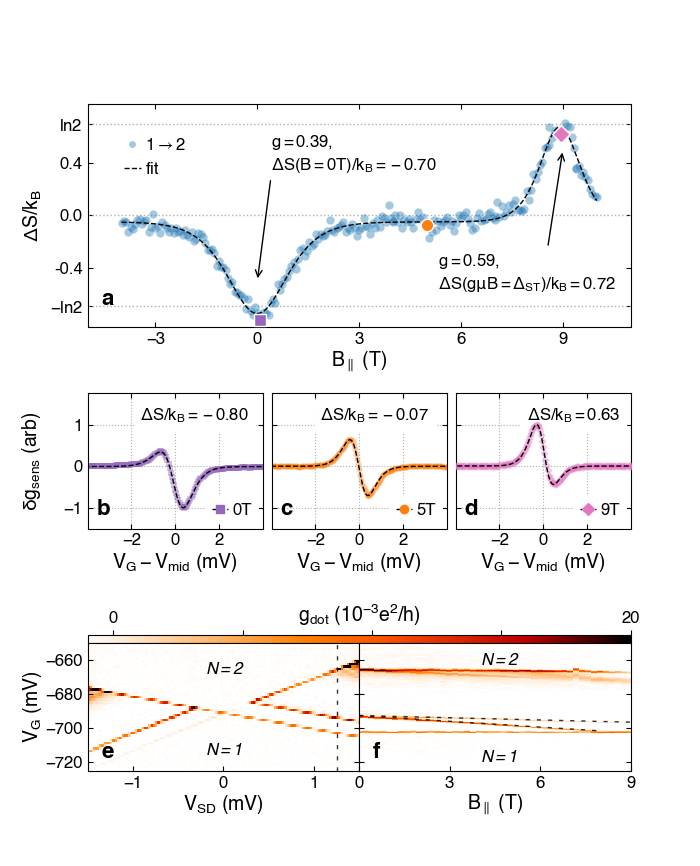

/usr/local/lib/python3.6/site-packages/matplotlib/mathtext.py:839: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


In [58]:
### setup figure ###
fig = plt.figure(figsize=dt.mm2inch((89*2,220)))

outer = gridspec.GridSpec(5, 1, height_ratios = [1.65,0.15,1,0.45,1])

gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0])
ax2 = fig.add_subplot(gs1[:]) # dS vs B

gs2 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec = outer[2],
                                           wspace=0.05)
ax3 = fig.add_subplot(gs2[0,0]) # dg 0T
ax4 = fig.add_subplot(gs2[0,1]) # dg 4T
ax5 = fig.add_subplot(gs2[0,2]) # dg 9T

gs3 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec = outer[4], 
                                           height_ratios = [0.06,1],
                                           wspace=0.0, hspace=0.0)

cax = fig.add_subplot(gs3[0,:]) # color bar
ax0 = fig.add_subplot(gs3[1,0]) # coulomb diamond
ax1 = fig.add_subplot(gs3[1,1]) # g factor data

# adjust left labels
ax2_ylabel_pos = (-0.16/2,0.5)
ax3_ylabel_pos = (-0.16*1.6,0.5)
ax0_ylabel_pos = (-0.16,0.5)

###############
### dS vs B ###
###############

df = pd.read_csv(os.path.join(analysis_dir, 'dat1284-1290_di_free_fits.csv'))
ax2.scatter(df['field'], -1.0*df['epsilon'], 
               marker='o', color='C0', lw=0, alpha = 0.4, zorder=2)

field = np.loadtxt(os.path.join(analysis_dir, 'dat1284-1290_field.csv'), delimiter=',')
dS = np.loadtxt(os.path.join(analysis_dir, 'dat1284-1290_dS12_fit.csv'), delimiter=',')
ax2.plot(field, dS, c='k', ls='--', zorder=3)
ax2.axhline(y=np.log(2), c='#b0b0b0', ls=':', zorder=1)
ax2.axhline(y=0, c='#b0b0b0', ls=':', zorder=1)
ax2.axhline(y=-1*np.log(2), c='#b0b0b0', ls=':', zorder=1)

ax2.set_xlim(-5, 11)
ax2.set_ylim(-0.85, 0.85)

scatter_12 = mpl.lines.Line2D([], [], ls='', 
                               marker='o', color='C0', alpha=0.4, 
                               markeredgewidth=0, markersize=5, 
                               label=r'$1 \rightarrow 2$')
line_12 = mpl.lines.Line2D([], [], color='k', ls='--', 
                               label=r'$fit$')
handles = [scatter_12, line_12]
labels = [h.get_label() for h in handles] 

ax2.legend(handles=handles, labels=labels, bbox_to_anchor=(0.2, 0.9))

ax2.annotate(r'$g = {0:.2f}$,'.format(0.394) + '\n' +
    r'$\Delta S(B=0T) / k_B = {0:.2f}$'.format(-1.007*np.log(2)),
            xy=(0.0, -0.5), xycoords='data',
            xytext=(10, 80), textcoords='offset points', fontsize=12, 
            arrowprops=dict(arrowstyle='->', relpos=(0., 0.)))

ax2.annotate(r'$g = {0:.2f}$,'.format(0.586) + '\n' + 
    r'$\Delta S(g \mu B=\Delta_{{ST}}) / k_B = {0:.2f}$'.format(1.043*np.log(2)),
            xy=(9.0, 0.5), xycoords='data',
            xytext=(-90, -100), textcoords='offset points', fontsize=12, 
            arrowprops=dict(arrowstyle='->', relpos=(0.6, 0.6)))

ax2.set_yticks([-1*np.log(2), -0.4, 0.0, 0.4, np.log(2)])
ax2.set_yticklabels([r'$-\ln{2}$', '-0.4', '0.0', '0.4', r'$\ln{2}$'])
ax2.set_xticks([-3,0,3,6,9])
ax2.set_ylabel('$\Delta S/k_B$')
ax2.get_yaxis().set_label_coords(*ax2_ylabel_pos)
ax2.set_xlabel('B$_{\parallel}$ (T)')

#############################
### markers for line cuts ###
#############################

ax2.scatter(df.loc[61,'field'], -1.0*df.loc[61,'epsilon'], marker='s', s=80, zorder=4, 
            facecolors='C4', edgecolors='w')
ax2.scatter(df.loc[136,'field'], -1.0*df.loc[136,'epsilon'], marker='o', s=80, zorder=4, 
            facecolors='C1', edgecolors='w')
ax2.scatter(df.loc[197,'field'], -1.0*df.loc[196,'epsilon'], marker='D', s=80, zorder=4, 
            facecolors='C6', edgecolors='w')

#####################################
### dg at B=0 and B=5T and B=8.9T ###
#####################################

swp = dt.open_hdf5(1284, path=data_dir) # load sweep data
vx, vz = dt.moving_avg(swp['x_array'][:]*0.5, swp['g5x2d'][:]*2e-8, 6, axis=1)
vz = vz*(1e3)/(35e-3*1e-2)/(3.874e-5) # 0.001e^2/h
vz = vz/np.abs(vz[61]).max()

ax3.scatter(vx-df.iloc[61,0], -vz[61], 
                marker='s', s=18, c='C4', lw=0, alpha=0.4)
di_fit = dt.di_sense_simple(vx, *df.iloc[61,:-1].values)
ax3.plot(vx-df.iloc[61,0], di_fit/np.abs(di_fit).max(), 
             c='k', ls='--')
ax3.text(0.92, 0.80, r'$\Delta S/k_B={0:.2f}$'.format(-1.0*df['epsilon'][61]), 
         transform=ax3.transAxes, fontsize=12, ha='right', backgroundcolor='w')
line0T = mpl.lines.Line2D([], [], color='k', ls='--', label='0T', 
                              marker = 's', markerfacecolor='C4', markeredgecolor='C4')
handles = [line0T]
labels = [h.get_label() for h in handles] 
ax3.legend(handles=handles, labels=labels, fontsize=12, loc='lower right',
            frameon=True, facecolor='w', edgecolor='none', framealpha=1)

swp = dt.open_hdf5(1285, path=data_dir) # load sweep data
vx, vz = dt.moving_avg(swp['x_array'][:]*0.5, swp['g5x2d'][:]*2e-8, 8, axis=1)
vz = vz*(1e3)/(35e-3*1e-2)/(3.874e-5) # 0.001e^2/h
vz = vz/np.abs(vz[15]).max()/np.sqrt(2)

ax4.scatter(vx-df.iloc[136,0], -vz[15],
            marker='o', s=18, c='C1', lw=0, alpha=0.4)
di_fit = dt.di_sense_simple(vx, *df.iloc[136,:-1].values)
ax4.plot(vx-df.iloc[136,0], di_fit/np.abs(di_fit).max()/np.sqrt(2), 
         c='k', ls='--')
ax4.text(0.90, 0.80, r'$\Delta S/k_B={0:.2f}$'.format(-1.0*df['epsilon'][136]), 
         transform=ax4.transAxes, fontsize=12, ha='right', backgroundcolor='w')
line5T = mpl.lines.Line2D([], [], color='k', ls='--', label='5T', 
                              marker = 'o', markerfacecolor='C1', markeredgecolor='C1')
handles = [line5T]
labels = [h.get_label() for h in handles] 
ax4.legend(handles=handles, labels=labels, fontsize=12, loc='lower right',
            frameon=True, facecolor='w', edgecolor='none', framealpha=1)

swp = dt.open_hdf5(1288, path=data_dir) # load sweep data
vx, vz = dt.moving_avg(swp['x_array'][:]*0.5, swp['g5x2d'][:]*2e-8, 8, axis=1)
vz = vz*(1e3)/(35e-3*1e-2)/(3.874e-5) # 0.001e^2/h
vz = vz/np.abs(vz[5]).max()

ax5.scatter(vx-df.iloc[197,0], -vz[5], 
            marker='D', s=18, c='C6', lw=0, alpha=0.4, zorder=4)
di_fit = dt.di_sense_simple(vx, *df.iloc[197,:-1].values)
ax5.plot(vx-df.iloc[197,0], di_fit/np.abs(di_fit).max(), 
         c='k', ls='--', zorder=4)
ax5.text(0.94, 0.80, r'$\Delta S/k_B={0:.2f}$'.format(-1.0*df['epsilon'][197]), 
         transform=ax5.transAxes, fontsize=12, ha='right', backgroundcolor='w')
line9T = mpl.lines.Line2D([], [], color='k', ls='--', label='9T',
                              marker = 'D', markerfacecolor='C6', markeredgecolor='C6')
handles = [line9T]
labels = [h.get_label() for h in handles] 
ax5.legend(handles=handles, labels=labels, loc='lower right',
           frameon=True, facecolor='w', edgecolor='none', framealpha=1)

for a in[ax3, ax4, ax5]:
    a.set_xlim(-4,4)
    a.set_xticks([-2,0,2])
    a.set_ylim(-1.5, 1.75)
    a.set_yticks([-1, 0, 1])
    a.grid(ls=':')
    a.set_xlabel(r'$V_G-V_{mid}$ (mV)')

ax4.set_yticklabels([])
ax5.set_yticklabels([])
ax3.set_ylabel(r'$\delta g_{sens}$ (arb)')
ax3.get_yaxis().set_label_coords(*ax3_ylabel_pos)

#######################
### coulomb diamond ###
#######################

swp = dt.open_hdf5(1087, path=data_dir) # load sweep
xx, yy = dt.xy_to_meshgrid(swp['x_array'][:]*0.01, swp['y_array'][:]*0.5)
cond = swp['g_dot2d'][:]*1000

vmin = -1; vmid = 3; vmax = 20
midpoint = 1 - np.abs(vmid-vmin)/np.abs(vmax-vmin)
cdmap = dt.shiftedColorMap(plt.cm.gist_heat_r, midpoint=midpoint, name='shiftedcmap')

im = ax0.pcolormesh(xx, yy, cond, cmap=cdmap, vmin=vmin, vmax=vmax, zorder=-1)
ax0.axvline(x=1.25, color='k', linestyle='--', dashes=(3, 5), alpha=0.8)

ax0.text(-0.2, -668, r'$N=2$', fontsize=12, fontstyle='italic')
ax0.text(-0.2, -716, r'$N=1$', fontsize=12, fontstyle='italic')

ax0.set_ylim(-725, -650)
ax0.set_yticks([-720, -700, -680, -660])
ax0.set_ylabel('V$_{G}$ (mV)')
ax0.get_yaxis().set_label_coords(*ax0_ylabel_pos)
ax0.set_xlim(-1.5, 1.5)
ax0.set_xticks([-1.0, 0, 1.0])
ax0.set_xlabel('V$_{SD}$ (mV)')
ax0.tick_params(axis='both', top=False)

####################
### add colorbar ###
####################

cb = plt.colorbar(cax = cax, mappable = im, 
                    orientation = 'horizontal', ticklocation = 'top')
cb.set_ticks([0, 5, 10, 15, 20])
cb.set_ticklabels(['0','','','','20'])
cb.set_label(r'g$_{dot}$ ($10^{-3}e^2$/h)', labelpad=-8)
cb.ax.tick_params(axis='x', direction='out')

##########################
### plot g factor data ###
##########################

df = pd.read_csv(os.path.join(analysis_dir,'dat1082-1084_gfactor_fits.csv'))
dats = [1082, 1083, 1084]
ns = [-5, None, None]
for n, dat in zip(ns, dats):
    # import data
    swp = dt.open_hdf5(dat, path=data_dir) # load sweep
    xplt = np.loadtxt(os.path.join(analysis_dir, 'dat{0:d}_xplt.csv'.format(dat)),
                        delimiter=',')
    yplt = np.loadtxt(os.path.join(analysis_dir, 'dat{0:d}_yplt.csv'.format(dat)),
                        delimiter=',')
    xshift = np.loadtxt(os.path.join(analysis_dir, 'dat{0:d}_xshift.csv'.format(dat)), 
                          delimiter=',')
    z = swp['g_dot2d'][:n]*1000

    for i in range(len(z)):
        xx, yy = np.meshgrid(np.array([yplt[i], yplt[i+1]]), 
                                 (xplt - xshift[i])+df.loc[0,'gate_offset'])
        ax1.pcolormesh(xx, yy, z[i,None].transpose(), 
                       cmap=cdmap, vmin=vmin, vmax=vmax, zorder=-1)
            
fields = np.linspace(0,8, 200)
ax1.plot(fields, df.loc[0,'a0']*fields+df.loc[0,'b0']+df.loc[0,'gate_offset'], 
            c='k', linestyle='--', dashes=(3, 5), alpha=0.8)
fields = np.linspace(0,9, 200)
ax1.plot(fields, df.loc[0,'a1']*fields+df.loc[0,'b1']+df.loc[0,'gate_offset'], 
            c='k', linestyle='--', dashes=(3, 5), alpha=0.8)

ax1.text(4, -663, r'$N=2$', fontsize=12, fontstyle='italic')
ax1.text(4, -720, r'$N=1$', fontsize=12, fontstyle='italic')

# subplot labels
ax1.set_xlabel('B$_{\parallel}$ (T)')
ax1.set_xlim(0, 9)
ax1.set_xticks([0, 3, 6, 9])
ax1.set_ylim(-725, -650)
ax1.set_yticks([-720, -700, -680, -660])
ax1.set_yticklabels([])
ax1.tick_params(axis='both', top=False)

dt.add_subplot_id(ax2, 'a', loc = (0.025,0.1))
dt.add_subplot_id(ax3, 'b', loc = (0.05,0.1))
dt.add_subplot_id(ax4, 'c', loc = (0.05,0.1))
dt.add_subplot_id(ax5, 'd', loc = (0.05,0.1))
dt.add_subplot_id(ax0, 'e', loc = (0.05,0.1))
dt.add_subplot_id(ax1, 'f', loc = (0.05,0.1))

fig.savefig(os.path.join(fig_dir, 'figure_4.pdf'))